This notebook is used to convert `.npy` files to `.trace` files.

In [1]:
import os, glob
import itertools
import numpy as np
from matplotlib import pyplot as plt

In [2]:
class DeepShape(list):
    "Shape of a nested array"
    def __init__(self, *shapes):
        super().__init__(shapes)

    @classmethod
    def inspect(cls, obj):
        "Return the DeepShape of a nested-array-like object."
        if isinstance(obj, (list,tuple)):
            subshape = cls.merge.from_iterable(
                cls.inspect(sub)
                for i,sub in enumerate(obj)
            )
            return cls(len(obj), *subshape)
        elif isinstance(obj, np.ndarray):
            subshape = cls.merge.from_iterable(
                cls.inspect(sub)
                for i,sub in np.ndenumerate(obj)
            )
            return cls(obj.shape, *subshape)
        else:
            return cls(type(obj))
            
    @classmethod
    def _merge_from_iterable(cls, deepshapes):
        deepshapes = list(deepshapes)
        # itertools.zip_longest(*deepshapes, fillvalue=None)
        # ds = [s for s in deepshapes if s is not None]
        # if not ds: return None
        # ds = [shape[0] for shape in deepshapes if len(shape)>0]
        ds = [shape[0] if len(shape)>0 else None for shape in deepshapes]
        if all(len(shape)==0 for shape in deepshapes): return cls()
        # if not ds: return cls()
        # if all(s is None for s in ds): return cls()
        subshapes = lambda: cls._merge_from_iterable(shape[1:] for shape in deepshapes)
        if all(isinstance(s,(int,range)) for s in ds): # list,tuple
            start = min(s.start if isinstance(s, range) else s for s in ds)
            stop = max(s.stop if isinstance(s, range) else s+1 for s in ds)
            s = start if start==stop-1 else range(start, stop)
            return cls(s, *subshapes())
        elif all(isinstance(s,tuple) for s in ds): # numpy array
            if any(len(s) != len(ds[0]) or s==(...,) for s in ds): s = (...,)
            else:
                s = tuple(cls._merge_from_iterable(ds))
            return cls(s, *subshapes())
        elif all(isinstance(s,type) for s in ds):
            for t in ds:
                if all(issubclass(s,t) for s in ds): break
            else: t = object
            return cls(t, *subshapes())
        return cls(..., *subshapes())
    # @classmethod
    def merge(cls, *deepshapes):
        "Returns the most generic shape describing all of these shapes."
        return cls._merge_from_iterable(deepshapes)
    # merge.from_iterable = _merge_from_iterable
    # merge = classmethod(merge)
    
    def __repr__(self) -> str:
        stext=[]
        for s in self:
            if isinstance(s, int): stext.append(f"[{s}]")
            elif isinstance(s, range): stext.append(f"[{s.start}:{s.stop-1}]")
            elif isinstance(s, tuple):
                sstext=[]
                for ss in s:
                    if isinstance(ss, int): sstext.append(f"{ss}")
                    elif isinstance(ss, range): sstext.append(f"{ss.start}:{ss.stop-1}")
                    elif ss==Ellipsis: sstext.append(f"...")
                stext.append(f"[{''.join(f'{sst},' for sst in sstext)}]")
            elif s==Ellipsis: stext.append(f"<...>")
            elif isinstance(s, type): stext.append(f"<{s.__name__}>")
            else: stext.append(f"{s}")
        return ''.join(stext)


    def __and__(self, other):
        assert isinstance(other, __class__)
        return self.merge(self, other)
DeepShape.merge.from_iterable = DeepShape._merge_from_iterable
DeepShape.merge = classmethod(DeepShape.merge)
# DeepShape.merge.from_iterable

inspect = DeepShape.inspect

----
## First dataset

UAV abstract features:
- `x0`: no severe pitch; `!x0`: severe pitch
- `x1`: xy change; `!x1`: altitude change
- `x2`: thrust; `!x2`: glide
- `x3`: not smallest altitude; `!x3`: smallest altitude

In [83]:
dataset_dir = "dataset1"
trace_dir = f"{dataset_dir}/traces"
os.makedirs(trace_dir, exist_ok=True)

In [89]:
# inspect all .npy files
paths = f"{dataset_dir}/ta2/*.npy"
s = (40,25)
print(f"{f'PATH == ({paths}) '+'='*(s[0]-1):.{s[0]-1}} {'DEEPSHAPE '+'='*s[1]:.{s[1]}}")
for path in sorted(glob.glob(paths, recursive=True)):
    obj = np.load(path, allow_pickle=True)
    shape = inspect(obj)
    print(f"{f'{path} ':.<{s[0]-1}} {shape}")
print("="*sum(s))

PATH == (dataset1/ta2/*.npy) ========== DEEPSHAPE ===============
dataset1/ta2/20220601_uav_strats.npy .. [1000,][1:6][4,]<float64>
dataset1/ta2/all_dtw.npy .............. [6,]<...><float64>
dataset1/ta2/all_edit.npy ............. [6,]<...><float64>
dataset1/ta2/all_flex.npy ............. [6,]<...><float64>
dataset1/ta2/all_stretch.npy .......... [6,]<...><float64>
dataset1/ta2/dtw_distance.npy ......... [1000,1000,]<float64>
dataset1/ta2/edit_distance.npy ........ [1000,1000,]<float64>
dataset1/ta2/feature_0_dtw.npy ........ [6,]<...><float64>
dataset1/ta2/feature_0_edit.npy ....... [6,]<...><float64>
dataset1/ta2/feature_0_flex.npy ....... [6,]<...><float64>
dataset1/ta2/feature_0_stretch.npy .... [6,]<...><float64>
dataset1/ta2/feature_1_dtw.npy ........ [6,]<...><float64>
dataset1/ta2/feature_1_edit.npy ....... [6,]<...><float64>
dataset1/ta2/feature_1_flex.npy ....... [6,]<...><float64>
dataset1/ta2/feature_1_stretch.npy .... [6,]<...><float64>
dataset1/ta2/feature_2_dtw.npy .....

In [90]:
# load trajectories
trajs_path = f"{dataset_dir}/ta2/20220601_uav_strats.npy"
trajs = np.load(trajs_path, allow_pickle=True)
print(f"{len(trajs)} traces")
print(f"{len(trajs[0][0])} features")
inspect(trajs)

1000 traces
4 features


[1000,][1:6][4,]<float64>

In [91]:
# create all_traj.trace
trace_path = os.path.join(trace_dir, "all_traj.trace")
print('...', trace_path)
with open(trace_path, "w") as fp:
    for traj in trajs:
        line = ';'.join(','.join(f'{int(prop)}' for prop in event) for event in traj)
        print(line, file=fp)

... dataset1/traces/all_traj.trace


In [92]:
# convert .npy clusters to .trace
cluster_paths = f"{dataset_dir}/ta2/labels_*.npy"
for cluster_path in sorted(glob.glob(cluster_paths, recursive=True)):
    print('>>>', cluster_path)
    filename = os.path.splitext(os.path.basename(cluster_path))[0]
    labels = np.load(cluster_path, allow_pickle=True)
    for cluster_no in np.unique(labels):
        trace_path = os.path.join(trace_dir, f'{filename}_{cluster_no}.trace')
        print('...', trace_path)
        cluster_trajs = trajs[np.where(labels==cluster_no)]
        with open(trace_path, "w") as fp:
            for traj in cluster_trajs:
                line = ';'.join(','.join(f'{int(prop)}' for prop in event) for event in traj)
                print(line, file=fp)

>>> dataset1/ta2/labels_0_dtw.npy
... dataset1/traces/labels_0_dtw_0.trace
... dataset1/traces/labels_0_dtw_1.trace
... dataset1/traces/labels_0_dtw_2.trace
... dataset1/traces/labels_0_dtw_3.trace
... dataset1/traces/labels_0_dtw_4.trace
>>> dataset1/ta2/labels_0_edit.npy
... dataset1/traces/labels_0_edit_0.trace
... dataset1/traces/labels_0_edit_1.trace
... dataset1/traces/labels_0_edit_2.trace
... dataset1/traces/labels_0_edit_3.trace
... dataset1/traces/labels_0_edit_4.trace
>>> dataset1/ta2/labels_0_flex.npy
... dataset1/traces/labels_0_flex_0.trace
... dataset1/traces/labels_0_flex_1.trace
... dataset1/traces/labels_0_flex_2.trace
... dataset1/traces/labels_0_flex_3.trace
... dataset1/traces/labels_0_flex_4.trace
>>> dataset1/ta2/labels_0_stretch.npy
... dataset1/traces/labels_0_stretch_0.trace
... dataset1/traces/labels_0_stretch_1.trace
... dataset1/traces/labels_0_stretch_2.trace
... dataset1/traces/labels_0_stretch_3.trace
... dataset1/traces/labels_0_stretch_4.trace
>>> data

----
## Second dataset

UAV abstract features
- `x0`:	reach_target
- `x1`:	severe_pitch
- `x2`:	vertical_motion
- `x3`:	glide
- `x4`:	increase_speed
- `x5`:	maintain_speed
- `x6`:	increase_altitude
- `x7`:	increase_pitch
- `x8`:	change_yaw
- `x9`:	change_roll
- `x10`:	low_battery

In [51]:
dataset_dir = "dataset2"
trace_dir = f"{dataset_dir}/traces"
os.makedirs(trace_dir, exist_ok=True)

In [52]:
# inspect all .npy files
paths = f"{dataset_dir}/*.npy"
s = (40,25)
print(f"{f'PATH == ({paths}) '+'='*(s[0]-1):.{s[0]-1}} {'DEEPSHAPE '+'='*s[1]:.{s[1]}}")
for path in sorted(glob.glob(paths, recursive=True)):
    obj = np.load(path, allow_pickle=True)
    shape = inspect(obj)
    print(f"{f'{path} ':.<{s[0]-1}} {shape}")
print("="*sum(s))

PATH == (dataset2/*.npy) ============== DEEPSHAPE ===============
dataset2/abs_traj_bool.npy ............ [10000,][1:3,11,]<uint8>
dataset2/cluster_labels.npy ........... [10000,]<int64>
dataset2/encodings_test.npy ........... [10000,4,]<float32>
dataset2/raw_traj_distance_matrix.npy . [100,100,]<float64>


In [5]:
# load trajectories
trajs_path = f"{dataset_dir}/abs_traj_bool.npy"
trajs = np.load(trajs_path, allow_pickle=True)
print(f"{len(trajs)} traces")
print(f"{len(trajs[0][0])} features")
inspect(trajs)

10000 traces
11 features


[10000,][1:3,11,]<uint8>

In [6]:
# create all_traj.trace
trace_path = os.path.join(trace_dir, "all_traj.trace")
print('...', trace_path)
with open(trace_path, "w") as fp:
    for traj in trajs:
        line = ';'.join(','.join(f'{int(prop)}' for prop in event) for event in traj)
        print(line, file=fp)

... dataset2/traces/all_traj.trace


### Raw trajs distance
`cluster_labels.npy`

In [7]:
# convert .npy clusters to .trace
cluster_paths = f"{dataset_dir}/cluster_labels.npy"
for cluster_path in sorted(glob.glob(cluster_paths, recursive=True)):
    print('>>>', cluster_path)
    filename = os.path.splitext(os.path.basename(cluster_path))[0]
    labels = np.load(cluster_path, allow_pickle=True)
    for cluster_no in np.unique(labels):
        trace_path = os.path.join(trace_dir, f'{filename}_{cluster_no}.trace')
        print('...', trace_path)
        cluster_trajs = trajs[np.where(labels==cluster_no)]
        with open(trace_path, "w") as fp: # save trace file
            for traj in cluster_trajs:
                line = ';'.join(','.join(f'{int(prop)}' for prop in event) for event in traj)
                print(line, file=fp)

>>> dataset2/cluster_labels.npy
... dataset2/traces/cluster_labels_0.trace
... dataset2/traces/cluster_labels_1.trace
... dataset2/traces/cluster_labels_2.trace


#### add negative trajectories from other clusters
`ta2_20220825.zip`

In [99]:
# load compressed trajectories
ctrajs_path = f"{dataset_dir}/encodings_test.npy"
ctrajs = np.load(ctrajs_path, allow_pickle=True)
# ctrajs = ctrajs[:100]
inspect(ctrajs)

[10000,4,]<float32>

In [101]:
# load mat of reference
mat_ref_path = f"{dataset_dir}/raw_traj_distance_matrix.npy"
mat_ref = np.load(mat_ref_path, allow_pickle=True)
# plt.imshow(mat_ref, vmin=0)
inspect(mat_ref)

[100,100,]<float64>

In [102]:
# check that mat can be reconstructed accurately
import scipy.spatial
mat = scipy.spatial.distance.pdist(ctrajs[:len(mat_ref)], 'cosine')/2
mat = scipy.spatial.distance.squareform(mat)
assert np.allclose(mat, mat_ref, atol=1e-6)
inspect(mat)

[100,100,]<float64>

In [104]:
# convert .npy clusters to .trace (include some negative trajectories)
import scipy.spatial

cluster_path = f"{dataset_dir}/cluster_labels.npy"
print('>>>', cluster_path)
filename = os.path.splitext(os.path.basename(cluster_path))[0]
labels = np.load(cluster_path, allow_pickle=True)
for cluster_no in np.unique(labels):
    trace_path = os.path.join(trace_dir, f'{filename}_{cluster_no}_ext.trace')
    print('...', trace_path)
    pos_trajs_i, = np.where(labels[:len(ctrajs)]==cluster_no)
    neg_trajs_i, = np.where(labels[:len(ctrajs)]!=cluster_no)

    # reorder negative traces
    dists = np.empty((len(neg_trajs_i),), dtype=float)
    cluster_ctrajs = ctrajs[pos_trajs_i]
    for j,i in enumerate(neg_trajs_i):
        ctraj_dists = scipy.spatial.distance.cdist(ctrajs[[i]], cluster_ctrajs, 'cosine')/2
        d = np.min(ctraj_dists[0])  # distance to closest point in cluster
        dists[j] = d
    sort = np.argsort(-dists)
    dists = dists[sort]
    neg_trajs_i = neg_trajs_i[sort]

    # # some checks
    # traj = trajs[neg_trajs_i[0]]
    # print(neg_trajs_i[[list(traj.flat) for traj in trajs[neg_trajs_i]].index(list(traj.flat))])
    # print(pos_trajs_i[[list(traj.flat) for traj in trajs[pos_trajs_i]].index(list(traj.flat))])
    # print(dists[0])

    with open(trace_path, "w") as fp:
        for traj in trajs[pos_trajs_i]:
            line = ';'.join(','.join(f'{int(prop)}' for prop in event) for event in traj)
            print(line, file=fp)
        print("---", file=fp)
        for traj in trajs[neg_trajs_i[:5]]:
            line = ';'.join(','.join(f'{int(prop)}' for prop in event) for event in traj)
            print(line, file=fp)
        print("---", file=fp)


>>> dataset2/cluster_labels.npy
... dataset2/traces/cluster_labels_0_ext.trace
... dataset2/traces/cluster_labels_1_ext.trace
... dataset2/traces/cluster_labels_2_ext.trace


In [105]:
labels[[4346,294]]
# trajs[[4346,294]]

array([2, 0])

In [195]:
# analyse clusters
cluster_paths = f"{dataset_dir}/cluster_labels.npy"
for cluster_path in sorted(glob.glob(cluster_paths, recursive=True)):
    print('>>>', cluster_path)
    filename = os.path.splitext(os.path.basename(cluster_path))[0]
    labels = np.load(cluster_path, allow_pickle=True)
    for cluster_no in np.unique(labels):
        pos_trajs_i, = np.where(labels==cluster_no)
        neg_trajs_i, = np.where(labels!=cluster_no)

        pos_trajs = [list(traj.flat) for traj in trajs[pos_trajs_i]]
        neg_trajs = [list(traj.flat) for traj in trajs[neg_trajs_i]]

        prop = np.average([pos_traj in neg_trajs for pos_traj in pos_trajs])
        print(f"{prop:.2%} of cluster {cluster_no} intersects with other clusters")

>>> dataset2/cluster_labels.npy
71.44% of cluster 0 intersects with other clusters
73.96% of cluster 1 intersects with other clusters
72.79% of cluster 2 intersects with other clusters


### Abstract trajs distance 1
`ta2_09072022.zip`

In [149]:
# inspect all .npy files
paths = f"{dataset_dir}/ta2_09072022/*.npy"
s = (50,20)
print(f"{f'PATH == ({paths}) '+'='*(s[0]-1):.{s[0]-1}} {'DEEPSHAPE '+'='*s[1]:.{s[1]}}")
for path in sorted(glob.glob(paths, recursive=True)):
    obj = np.load(path, allow_pickle=True)
    shape = inspect(obj)
    print(f"{f'{path} ':.<{s[0]-1}} {shape}")
print("="*sum(s))

PATH == (dataset2/ta2_09072022/*.npy) =========== DEEPSHAPE ==========
dataset2/ta2_09072022/labels_0_dtw.npy .......... [2,1000,]<float64>
dataset2/ta2_09072022/labels_0_edit.npy ......... [2,1000,]<float64>
dataset2/ta2_09072022/labels_0_flex.npy ......... [2,1000,]<float64>
dataset2/ta2_09072022/labels_0_stretch.npy ...... [2,1000,]<float64>
dataset2/ta2_09072022/labels_10_dtw.npy ......... [2,1000,]<float64>
dataset2/ta2_09072022/labels_10_edit.npy ........ [2,1000,]<float64>
dataset2/ta2_09072022/labels_10_flex.npy ........ [2,1000,]<float64>
dataset2/ta2_09072022/labels_10_stretch.npy ..... [2,1000,]<float64>
dataset2/ta2_09072022/labels_1_dtw.npy .......... [2,1000,]<float64>
dataset2/ta2_09072022/labels_1_edit.npy ......... [2,1000,]<float64>
dataset2/ta2_09072022/labels_1_flex.npy ......... [2,1000,]<float64>
dataset2/ta2_09072022/labels_1_stretch.npy ...... [2,1000,]<float64>
dataset2/ta2_09072022/labels_2_dtw.npy .......... [2,1000,]<float64>
dataset2/ta2_09072022/labels_2_e

In [114]:
# analyse clusters
cluster_paths = f"{dataset_dir}/ta2_09072022/*.npy"
for cluster_path in sorted(glob.glob(cluster_paths, recursive=True)):
    # print('>>>', cluster_path)
    filename = os.path.splitext(os.path.basename(cluster_path))[0]
    labels = np.load(cluster_path, allow_pickle=True)[0,:]
    for cluster_no in np.unique(labels):
        pos_trajs_i, = np.where(labels==cluster_no)
        neg_trajs_i, = np.where(labels!=cluster_no)

        pos_trajs = [list(traj.flat) for traj in trajs[pos_trajs_i]]
        neg_trajs = [list(traj.flat) for traj in trajs[neg_trajs_i]]

        prop = np.average([pos_traj in neg_trajs for pos_traj in pos_trajs])
        assert prop==0, f"cluster {cluster_path!r} is not separable"
        # print(f"{prop*100:.2f}% of cluster {cluster_no} intersects with other clusters")
print("all clusters are separable!")

all clusters are separable!


In [193]:
# inspect all .npy files
cluster_paths = f"{dataset_dir}/ta2_09072022/*.npy"
df_data = {}
for cluster_path in sorted(glob.glob(cluster_paths, recursive=True)):
    # print('>>>', cluster_path)
    filename = os.path.splitext(os.path.basename(cluster_path))[0]
    labels, cost = np.load(cluster_path, allow_pickle=True)
    labels = labels.astype(int)
    for cluster_no in np.unique(labels):
        pos_trajs_i, = np.where(labels==cluster_no)
        neg_trajs_i, = np.where(labels!=cluster_no)

        pos_trajs = [list(traj.flat) for traj in trajs[pos_trajs_i]]
        neg_trajs = [list(traj.flat) for traj in trajs[neg_trajs_i]]

        prop = np.average([pos_traj in neg_trajs for pos_traj in pos_trajs])
        assert prop==0, f"cluster {cluster_path!r} is not separable"
    df_data[cluster_path] = {
        "clusters": len(np.unique(labels)),
        "min(cost)": cost.min(),
        "max(cost)": cost.max(),
        "avg(cost)": cost.mean(),
        "cost==0 (%)": len(np.where(cost==0)[0])/len(cost),
    }
from pandas import DataFrame
print("all clusters are separable!")
DataFrame(df_data).T

all clusters are separable!


,clusters,min(cost),max(cost),avg(cost),cost==0 (%)
dataset2/ta2_09072022/labels_0_dtw.npy,3.0,0.0,0.750000,0.008917,0.987
dataset2/ta2_09072022/labels_0_edit.npy,3.0,0.0,0.500000,0.006167,0.987
dataset2/ta2_09072022/labels_0_flex.npy,1.0,0.0,0.000000,0.000000,1.000
dataset2/ta2_09072022/labels_0_stretch.npy,3.0,0.0,0.400000,0.005133,0.987
dataset2/ta2_09072022/labels_10_dtw.npy,3.0,0.0,0.250000,0.097000,0.612
dataset2/ta2_09072022/labels_10_edit.npy,3.0,0.0,1.000000,0.219333,0.721
dataset2/ta2_09072022/labels_10_flex.npy,1.0,0.0,0.000000,0.000000,1.000
dataset2/ta2_09072022/labels_10_stretch.npy,3.0,0.0,0.183333,0.004767,0.974
dataset2/ta2_09072022/labels_1_dtw.npy,3.0,0.0,0.750000,0.115167,0.678
dataset2/ta2_09072022/labels_1_edit.npy,3.0,0.0,0.666667,0.149000,0.678


In [159]:
# convert .npy clusters to .trace
cluster_paths = f"{dataset_dir}/ta2_09072022/*.npy"
for cluster_path in sorted(glob.glob(cluster_paths, recursive=True)):
    print('>>>', cluster_path)
    filename = os.path.splitext(os.path.basename(cluster_path))[0]
    labels, cost = np.load(cluster_path, allow_pickle=True)
    labels = labels.astype(int)
    for cluster_no in np.unique(labels):
        trace_path = os.path.join(trace_dir, f'{filename}_{cluster_no}.trace')
        print('...', trace_path)
        cluster_trajs = trajs[np.where(labels==cluster_no)]
        with open(trace_path, "w") as fp: # save trace file
            for traj in cluster_trajs:
                line = ';'.join(','.join(f'{int(prop)}' for prop in event) for event in traj)
                print(line, file=fp)

>>> dataset2/ta2_09072022/labels_0_dtw.npy
... dataset2/traces/labels_0_dtw_0.trace
... dataset2/traces/labels_0_dtw_1.trace
... dataset2/traces/labels_0_dtw_2.trace
>>> dataset2/ta2_09072022/labels_0_edit.npy
... dataset2/traces/labels_0_edit_0.trace
... dataset2/traces/labels_0_edit_1.trace
... dataset2/traces/labels_0_edit_2.trace
>>> dataset2/ta2_09072022/labels_0_flex.npy
... dataset2/traces/labels_0_flex_0.trace
>>> dataset2/ta2_09072022/labels_0_stretch.npy
... dataset2/traces/labels_0_stretch_0.trace
... dataset2/traces/labels_0_stretch_1.trace
... dataset2/traces/labels_0_stretch_2.trace
>>> dataset2/ta2_09072022/labels_10_dtw.npy
... dataset2/traces/labels_10_dtw_0.trace
... dataset2/traces/labels_10_dtw_1.trace
... dataset2/traces/labels_10_dtw_2.trace
>>> dataset2/ta2_09072022/labels_10_edit.npy
... dataset2/traces/labels_10_edit_0.trace
... dataset2/traces/labels_10_edit_1.trace
... dataset2/traces/labels_10_edit_2.trace
>>> dataset2/ta2_09072022/labels_10_flex.npy
... dat

### Abstract trajs distance 2
`ta2_09272022.zip`

In [53]:
# inspect all .npy files
paths = f"{dataset_dir}/ta2_09272022/*.npy"
s = (50,30)
print(f"{f'PATH == ({paths}) '+'='*(s[0]-1):.{s[0]-1}} {'DEEPSHAPE '+'='*s[1]:.{s[1]}}")
for path in sorted(glob.glob(paths, recursive=True)):
    obj = np.load(path, allow_pickle=True)
    shape = inspect(obj)
    print(f"{f'{path} ':.<{s[0]-1}} {shape}")

path = "dataset2/ta2_09272022/unique_trajs.npy"
obj = np.load("dataset2/ta2_09272022/unique_trajs.npy", allow_pickle=True)
for i,sub in enumerate(obj):
    shape = inspect(sub)
    print(f"{f'{path}[{i}] ':.<{s[0]-1}} {shape}")

print("="*sum(s))


PATH == (dataset2/ta2_09272022/*.npy) =========== DEEPSHAPE ====================
dataset2/ta2_09272022/labels_all_dtw.npy ........ [2,3323,]<float64>
dataset2/ta2_09272022/labels_all_edit.npy ....... [2,3323,]<float64>
dataset2/ta2_09272022/labels_all_flex.npy ....... [2,3323,]<float64>
dataset2/ta2_09272022/labels_all_stretch.npy .... [2,3323,]<float64>
dataset2/ta2_09272022/unique_trajs.npy .......... [3,][3323:10000,]<...><...>
dataset2/ta2_09272022/unique_trajs.npy[0] ....... [3323,][1:3,11,]<uint8>
dataset2/ta2_09272022/unique_trajs.npy[1] ....... [3323,]<int64>
dataset2/ta2_09272022/unique_trajs.npy[2] ....... [10000,]<int64>


In [54]:
# load unique trajectories
# see https://gitlab.com/draper-caml/alpaca/-/blob/master/alpaca/ta1/clustering.py#L132
u_trajs_path = f"{dataset_dir}/ta2_09272022/unique_trajs.npy"
u_trajs, u_counts, u_inverse = np.load(u_trajs_path, allow_pickle=True)
print(f"{len(u_inverse)} traces ({len(u_trajs)} unique)")

10000 traces (3323 unique)


In [55]:
# create all_u_traj.trace
trace_path = os.path.join(trace_dir, "all_u_traj.trace")
print('...', trace_path)
with open(trace_path, "w") as fp:
    for traj, count in zip(u_trajs, u_counts):
        line = ';'.join(','.join(f'{int(prop)}' for prop in event) for event in traj)
        suffix = ""
        if count!=1: suffix += f"[{count}]"
        if suffix: line = f"{line}::{suffix}"
        print(line, file=fp)

... dataset2/traces/all_u_traj.trace


In [37]:
# check that the dataset can be reconstructed
for t1, t2 in zip(trajs, u_trajs[u_inverse]):
    assert np.allclose(t1, t2)
inspect(trajs)

[10000,][1:3,11,]<uint8>

In [22]:
# convert .npy clusters to .trace
cluster_paths = f"{dataset_dir}/ta2_09272022/labels_all_*.npy"
for cluster_path in sorted(glob.glob(cluster_paths, recursive=True)):
    print('>>>', cluster_path)
    filename = os.path.splitext(os.path.basename(cluster_path))[0]
    labels, cost = np.load(cluster_path, allow_pickle=True)
    labels = labels.astype(int)
    for cluster_no in np.unique(labels):
        trace_path = os.path.join(trace_dir, f'{filename}_{cluster_no}.trace')
        print('...', trace_path)
        cluster_trajs = u_trajs[np.where(labels==cluster_no)]
        cluster_counts = u_counts[np.where(labels==cluster_no)]
        with open(trace_path, "w") as fp: # save trace file
            for traj, count in zip(cluster_trajs, cluster_counts):
                line = ';'.join(','.join(f'{int(prop)}' for prop in event) for event in traj)
                suffix = ""
                if count!=1: suffix += f"[{count}]"
                if suffix: line = f"{line}::{suffix}"
                print(line, file=fp)

>>> dataset2/ta2_09272022/labels_all_dtw.npy
... dataset2/traces/labels_all_dtw_0.trace
... dataset2/traces/labels_all_dtw_1.trace
... dataset2/traces/labels_all_dtw_2.trace
... dataset2/traces/labels_all_dtw_3.trace
>>> dataset2/ta2_09272022/labels_all_edit.npy
... dataset2/traces/labels_all_edit_0.trace
... dataset2/traces/labels_all_edit_1.trace
... dataset2/traces/labels_all_edit_2.trace
>>> dataset2/ta2_09272022/labels_all_flex.npy
... dataset2/traces/labels_all_flex_0.trace
... dataset2/traces/labels_all_flex_1.trace
... dataset2/traces/labels_all_flex_2.trace
>>> dataset2/ta2_09272022/labels_all_stretch.npy
... dataset2/traces/labels_all_stretch_0.trace
... dataset2/traces/labels_all_stretch_1.trace
... dataset2/traces/labels_all_stretch_2.trace


/home/jraph/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


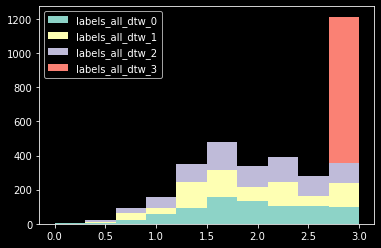

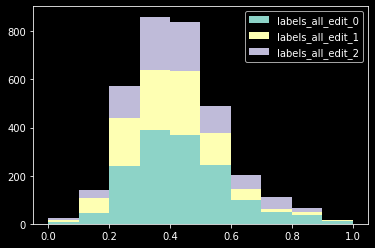

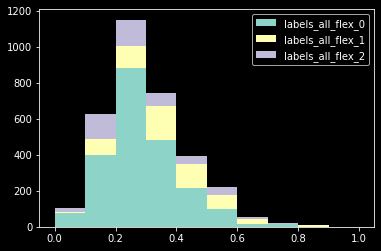

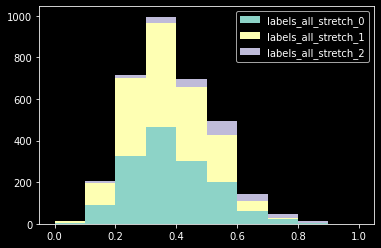

all clusters are separable!


,clusters,min(cost),max(cost),avg(cost),cost==0 (%)
dataset2/ta2_09272022/labels_all_dtw.npy,4.0,0.0,3.0,2.220554,0.000903
dataset2/ta2_09272022/labels_all_edit.npy,3.0,0.0,1.0,0.421998,0.000903
dataset2/ta2_09272022/labels_all_flex.npy,3.0,0.0,1.0,0.302130,0.020764
dataset2/ta2_09272022/labels_all_stretch.npy,3.0,0.0,1.0,0.384598,0.000903


In [49]:
# inspect all .npy files
cluster_paths = f"{dataset_dir}/ta2_09272022/labels_all_*.npy"
df_data = {}
for cluster_path in sorted(glob.glob(cluster_paths, recursive=True)):
    # print('>>>', cluster_path)
    filename = os.path.splitext(os.path.basename(cluster_path))[0]
    labels, cost = np.load(cluster_path, allow_pickle=True)
    labels = labels.astype(int)
    for cluster_no in np.unique(labels):
        pos_trajs_i, = np.where(labels==cluster_no)
        neg_trajs_i, = np.where(labels!=cluster_no)

        pos_trajs = [list(traj.flat) for traj in u_trajs[pos_trajs_i]]
        neg_trajs = [list(traj.flat) for traj in u_trajs[neg_trajs_i]]

        prop = np.average([pos_traj in neg_trajs for pos_traj in pos_trajs])
        assert prop==0, f"cluster {cluster_path!r} is not separable"
    plt.hist(
        x=[cost[np.where(labels==cluster_no)] for cluster_no in np.unique(labels)],
        label=[f"{filename}_{cluster_no}" for cluster_no in np.unique(labels)],
        histtype='barstacked')
    plt.legend(); plt.show()
    df_data[cluster_path] = {
        "clusters": len(np.unique(labels)),
        "min(cost)": cost.min(),
        "max(cost)": cost.max(),
        "avg(cost)": cost.mean(),
        "cost==0 (%)": len(np.where(cost==0)[0])/len(cost),
    }
    # plt.hist(cost, label=f"{filename}", histtype='step')
    # plt.legend()
from pandas import DataFrame
print("all clusters are separable!")
DataFrame(df_data).T

In [57]:
# convert .npy clusters to .trace (include some negative trajectories)
cluster_paths = f"{dataset_dir}/ta2_09272022/labels_all_*.npy"
pos_percentile = .5 # consider this percentage of the current cluster as positive data
neg_percentile = .1 # for each other cluster, consider this percentage as negative data
ignored_labels = [3] # "None" category (skipped)
for cluster_path in sorted(glob.glob(cluster_paths, recursive=True)):
    print('>>>', cluster_path)
    filename = os.path.splitext(os.path.basename(cluster_path))[0]
    labels, cost = np.load(cluster_path, allow_pickle=True)
    labels = labels.astype(int)
    cluster_idx    = {cluster_no:np.where(labels==cluster_no)[0] for cluster_no in np.unique(labels)}
    cluster_trajs  = {cluster_no:u_trajs[idx]  for cluster_no,idx in cluster_idx.items()}
    cluster_counts = {cluster_no:u_counts[idx] for cluster_no,idx in cluster_idx.items()}
    cluster_cost   = {cluster_no:cost[idx]     for cluster_no,idx in cluster_idx.items()}
    for cluster_no in np.unique(labels):
        if cluster_no in ignored_labels: continue
        trace_path = os.path.join(trace_dir, f'{filename}_{cluster_no}_ext.trace')
        print('...', trace_path)
        pos_trajs_i, neg_trajs_i = [], []

        cost_thres = np.quantile(cluster_cost[cluster_no],pos_percentile)
        trajs_i = cluster_idx[cluster_no][np.where(cluster_cost[cluster_no]<=cost_thres)]
        pos_trajs_i.extend(trajs_i)

        for other_cluster_no in np.unique(labels):
            if other_cluster_no in ignored_labels: continue
            if other_cluster_no == cluster_no: continue
            cost_thres = np.quantile(cluster_cost[other_cluster_no],neg_percentile)
            trajs_i = cluster_idx[other_cluster_no][np.where(cluster_cost[other_cluster_no]<=cost_thres)]
            neg_trajs_i.extend(trajs_i)
        
        with open(trace_path, "w") as fp:
            for traj, count in zip(u_trajs[pos_trajs_i], u_counts[pos_trajs_i]):
                line = ';'.join(','.join(f'{int(prop)}' for prop in event) for event in traj)
                suffix = ""
                if count!=1: suffix += f"[{count}]"
                if suffix: line = f"{line}::{suffix}"
                print(line, file=fp)
            print("---", file=fp)
            for traj, count in zip(u_trajs[neg_trajs_i], u_counts[neg_trajs_i]):
                line = ';'.join(','.join(f'{int(prop)}' for prop in event) for event in traj)
                suffix = ""
                if count!=1: suffix += f"[{count}]"
                if suffix: line = f"{line}::{suffix}"
                print(line, file=fp)
            print("---", file=fp)

>>> dataset2/ta2_09272022/labels_all_dtw.npy
... dataset2/traces/labels_all_dtw_0_ext.trace
... dataset2/traces/labels_all_dtw_1_ext.trace
... dataset2/traces/labels_all_dtw_2_ext.trace
>>> dataset2/ta2_09272022/labels_all_edit.npy
... dataset2/traces/labels_all_edit_0_ext.trace
... dataset2/traces/labels_all_edit_1_ext.trace
... dataset2/traces/labels_all_edit_2_ext.trace
>>> dataset2/ta2_09272022/labels_all_flex.npy
... dataset2/traces/labels_all_flex_0_ext.trace
... dataset2/traces/labels_all_flex_1_ext.trace
... dataset2/traces/labels_all_flex_2_ext.trace
>>> dataset2/ta2_09272022/labels_all_stretch.npy
... dataset2/traces/labels_all_stretch_0_ext.trace
... dataset2/traces/labels_all_stretch_1_ext.trace
... dataset2/traces/labels_all_stretch_2_ext.trace
